In [1]:
import torch
from torch import nn
from torch import functional as F

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Data Exploration

In [4]:
train = pd.read_csv('/content/gdrive/My Drive/sentiment_analysis_on_movie_reviews/products_sentiment_train.tsv', sep = '\t', header = None, names = ['text', 'y'])
test = pd.read_csv('/content/gdrive/My Drive/sentiment_analysis_on_movie_reviews/products_sentiment_test.tsv', sep = '\t')

In [5]:
train.head()

,text,y
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


In [6]:
test.head()

,Id,text
0,0,"so , why the small digital elph , rather than ..."
1,1,3/4 way through the first disk we played on it...
2,2,better for the zen micro is outlook compatibil...
3,3,6 . play gameboy color games on it with goboy .
4,4,"likewise , i 've heard norton 2004 professiona..."


In [7]:
train['y'].value_counts()

1    1274
0     726
Name: y, dtype: int64

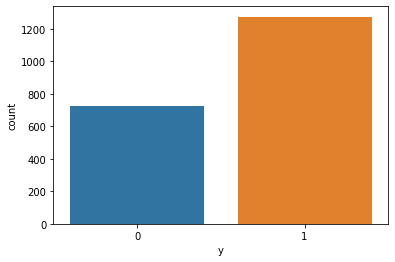

In [8]:
sns.countplot(train.y)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   y       2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


## Data Preprocessing


### Data Cleaning 

In [10]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.metrics.scores import precision, recall, f_measure
lemmatizer = WordNetLemmatizer()

import re
from bs4 import BeautifulSoup

import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
def preprocess_text(text):
    text = BeautifulSoup(text).get_text()
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = text.lower().replace('ё', 'е')
    words = word_tokenize(text)
    lemma_words = [lemmatizer.lemmatize(i) for i in words]
    return lemma_words

def preprocess_for_lang(data):
    text = [preprocess_text(t) for t in data['text']]
    
    return pd.Series(text)

In [13]:
text = preprocess_for_lang(train)
labels = train['y']

test_text = preprocess_for_lang(test)

In [14]:
test_text

0      [so, why, the, small, digital, elph, rather, t...
1      [3, 4, way, through, the, first, disk, we, pla...
2      [better, for, the, zen, micro, is, outlook, co...
3      [6, play, gameboy, color, game, on, it, with, ...
4      [likewise, i, ve, heard, norton, 2, 4, profess...
                             ...                        
495    [i, took, perfect, care, of, this, player, and...
496                 [it, s, a, very, intuitive, program]
497    [the, only, drawback, is, the, viewfinder, is,...
498    [it, film, 1, second, video, for, cry, out, loud]
499                     [everything, shine, of, quality]
Length: 500, dtype: object

### Data Vectorization

In [ ]:
!pip install transformers

import transformers as ppb

model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model_bert = model_class.from_pretrained(pretrained_weights)

In [16]:
import torch

def text_to_hidden_states(tokenizer, model, X):

    tokenized = X.apply(lambda x: tokenizer.encode(x, add_special_tokens = True))
    max_len = 0

    for i in tokenized.values:
        if len(i) > max_len:
          max_len = len(i)

    padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])

    attention_mask = torch.tensor(np.where(padded != 0, 1, 0))
    input_ids = torch.tensor(padded).to(torch.int64) 

    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask = attention_mask)

    return last_hidden_states[0]

In [17]:
def hidden(tokenizer, model, X_train, X_val, X_test, y_train, y_val):

    X_train = text_to_hidden_states(tokenizer, model, X_train)
    X_val = text_to_hidden_states(tokenizer, model, X_val)
    X_test = text_to_hidden_states(tokenizer, model, X_test)

    y_train = torch.from_numpy(np.array(y_train).astype(int))
    y_val = torch.from_numpy(np.array(y_val).astype(int))

    return X_train, X_val, X_test, y_train, y_val

In [18]:
X_train, X_val, y_train, y_val = train_test_split(text, labels, test_size = 0.2, random_state = 42)

In [19]:
X_train, X_val, X_test, y_train, y_val = hidden(tokenizer, model_bert, X_train, X_val, test_text, y_train, y_val)

## Model

In [20]:
class CNNBaseline(nn.Module):
    def __init__(self, D, kernel_sizes, num_filters = 3):
        super(CNNBaseline, self).__init__()
        self.convs = nn.ModuleList([nn.Conv1d(in_channels=D, out_channels=num_filters, kernel_size=K) for K in kernel_sizes])
        self.linear = nn.Linear(len(kernel_sizes) * num_filters, 2)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = [torch.nn.functional.relu(conv(x)) for conv in self.convs]
        x = [torch.nn.functional.max_pool1d(conv, conv.shape[2]) for conv in x] 
        x = torch.cat(x, dim=1).squeeze(2)

        out = self.linear(x)
        return out.squeeze()


kernel_sizes = [2] * 10 + [3] * 10 + [4] * 10 + [5] * 10
model = CNNBaseline(768, kernel_sizes)

loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

## Train Model

In [21]:
def batch_generator(X, y, batch_size):
    np.random.seed(42)
    perm = np.random.permutation(len(X))
    for start_index in range(0, len(perm), batch_size):
        batch_indexes = perm[start_index:start_index + batch_size]
        X_batch = X[batch_indexes]
        y_batch = y[batch_indexes]
        yield X_batch, y_batch

In [22]:
def train_epoch(model, X, y):
    model = model.train()
    losses = []
    correct_predictions = 0

    for X_batch, y_batch in batch_generator(X, y, 256):

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(X_batch)
        _, preds = torch.max(pred, dim=1)
        optimizer.zero_grad()
        loss = loss_fn(pred, y_batch)
        losses.append(loss.item())  
        loss.backward()
        optimizer.step()

        correct_predictions += torch.sum(preds == y_batch)
      
    return correct_predictions.double() / y.shape[0], np.mean(losses)

In [23]:
def eval_model(model, X, y):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for X_batch, y_batch in batch_generator(X, y, 256):

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(X_batch)
            _, preds = torch.max(pred, dim=1)
            loss = loss_fn(pred, y_batch)
            losses.append(loss.item())

            correct_predictions += torch.sum(preds == y_batch)
        
    return correct_predictions.double() / y.shape[0], np.mean(losses)

In [24]:
def train_model(mode, model, X_train, y_train, X_val, y_val, n_epoch):
    if mode == 'train':
        %%time
        history_train_loss = []
        history_val_loss = []
        history_train_acc = []
        history_val_acc = []
        best_accuracy = 0

        for epoch in range(n_epoch):

            train_acc, train_loss = train_epoch(model, X_train, y_train)
            val_acc, val_loss = eval_model(model, X_val, y_val)

            history_train_acc.append(train_acc)
            history_train_loss.append(train_loss)
            history_val_acc.append(val_acc)
            history_val_loss.append(val_loss)

            if val_acc > best_accuracy:
                torch.save(model.state_dict(), 'best_model_state.bin')
                best_accuracy = val_acc

        print()
        print(f'train loss {train_loss} accuracy {train_acc}')
        print(f'val   loss {val_loss} accuracy {val_acc}')

In [25]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

CNN = model.to(device)

In [26]:
train_model('train', CNN, X_train, y_train, X_val, y_val, 30)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs

train loss 0.024864014105073044 accuracy 0.998125
val   loss 0.41555437445640564 accuracy 0.845


In [27]:
pred = CNN(X_test.to(device))
_, preds = torch.max(pred, dim=1)

In [28]:
ans = pd.DataFrame({'Id' : np.arange(0, len(preds.cpu())), 'y' : np.array(preds.cpu())})

In [29]:
ans.to_csv('/content/gdrive/My Drive/sentiment_analysis_on_movie_reviews/submission.csv', index=False)

## Baseline

In [30]:
def report_baseline(X_train, y_train, X_test, y_test, model):

    if model == 'LogisticRegression':
        clf = LogisticRegression(random_state = 42)
        clf.fit(X_train[:, 0, :], y_train)

    elif model == 'RandomForestClassifier':
        clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
        clf.fit(X_train[:, 0, :], y_train)

    else:
        clf = SVC(kernel = 'rbf', gamma = 1e-3, C = 100)
        clf.fit(X_train[:, 0, :], y_train)

    return classification_report(clf.predict(X_test[:, 0, :]), y_test)

### Logistic Regression

In [31]:
print(report_baseline(X_train, y_train, X_val, y_val, 'LogisticRegression'))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76       141
           1       0.86      0.88      0.87       259

    accuracy                           0.83       400
   macro avg       0.82      0.81      0.82       400
weighted avg       0.83      0.83      0.83       400



### Random Forest Classifier

In [32]:
print(report_baseline(X_train, y_train, X_val, y_val, 'RandomForestClassifier'))

              precision    recall  f1-score   support

           0       0.69      0.66      0.68       140
           1       0.82      0.84      0.83       260

    accuracy                           0.78       400
   macro avg       0.76      0.75      0.75       400
weighted avg       0.78      0.78      0.78       400



### Support Vector Machine

In [33]:
print(report_baseline(X_train, y_train, X_val, y_val, 'SVM'))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       135
           1       0.88      0.88      0.88       265

    accuracy                           0.84       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.84      0.84      0.84       400

